In [1]:
import numpy as np
import math as math
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from yahoo_fin import options
from yahoo_fin.stock_info import get_data
from dateutil import parser
from datetime import datetime
from pandas_datareader.data import DataReader as dr
%matplotlib inline

# Blach-Scholes formula for a call option 
Function BSF Computes the value of a call with strike K and maturity T using Black-Scholes formula assuming the underlying asset has value S today (time 0) and volatility sigma 
r = risk free rate
The function Vega comnputes the derivative of the call price w.r.t. sigma

## price of a call

In [2]:
def BSF(S, K, T, sigma, r):
    
    if sigma == 0: 
        result = max(0, S-K*np.exp(-r*T))
    else: 
        d1 = (np.log(S / K) + (r + sigma**2/2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        # norm-cdf is the cumulative distribution function of N(0,1) 
        result = S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)
    
    return result

Text(0, 0.5, 'Price')

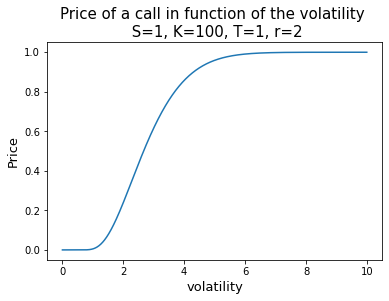

In [3]:
####   TEST 
S =1 
K = 100
T=1
r = 2
sigma_val = np.arange(0.01,10,0.01)

price = [BSF(S, K, T, sigma, r) for sigma in sigma_val]

plt.plot(sigma_val, price) 
plt.title(f'Price of a call in function of the volatility \n S={S}, K={K}, T={T}, r={r}', fontsize=15)
plt.xlabel('volatility', fontsize=13)
plt.ylabel('Price', fontsize=13)

## Computation of the implicit volatility 

### bissection algorithm to solve a nonlinear equation f(x)=0
Need two real numbers a and b such that a<b and f(a)f(b)<0 that is f has opposite sign in a and b and thus must have a zero somewhere in (a,b) (if f is continuous). It returns an estimate of the true solution with an error less than the parameter tol. 
This algorithm is slower than Newton-Raphson but is assured to converge once given a, b as before. 

In [4]:
def bissection(f,a,b,tol): 
    if f(a)*f(b)>0: 
        print('incorrect interval')
        return 
    if f(a)==0:
        return a 
    if f(b)==0: 
        return b
    while np.abs(b-a)>tol: 
        m = (a+b)/2
        if f(m)==0: 
            return m 
        else: 
            if f(m)*f(a)>0: 
                a = m 
            else: 
                b = m 
        
    return (a+b)/2

### Implicit volatility 
Given a time to maturity T, a strike price, the price S of the asset today and r the risk-free inteerst rate, find teh value of sigma such that the price of the call given by the BS formula is the real price C_real. 

In [5]:
def Implicit_volatility (S, T, r, K, C_real, a, b, tol): 
    f = lambda sigma: BSF(S, K, T, sigma, r) - C_real
    return bissection(f,a,b,tol) 

# Euler Maruyama scheme for the CEV model 

In [6]:
def EM(dt, T, mu, sigma, theta, X0): 
    N = int(T/dt)
    X = np.zeros(N+1)
    X[0] = X0
    dW = np.random.normal(loc = 0, scale = math.sqrt(dt), size = N)
    for k in range(N): 
        X[k+1] = X[k]*(1 + dt*mu) + sigma * X[k]**theta * dW[k]
    return X, dW

## One run of the EM scheme

Text(0.5, 1.0, 'One run of the CEV model \n$X_0=$1, $\\mu=$1, $\\sigma=$1, $\\theta=$0.5')

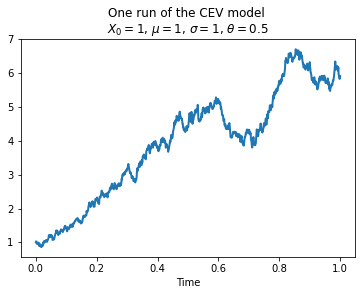

In [7]:
T = 1
dt = 0.001
N = int(T/dt)
t = np.linspace(0,1,N+1)
mu  = 1
sigma = 1
theta = 0.5
X0 = 1
X, dW = EM(dt, T, mu, sigma, theta, X0)

fig, ax = plt.subplots()
ax.plot(t, X, linewidth = 2)
ax.set_xlabel('Time')
title = 'One run of the CEV model \n' + r'$X_0=$' + str(X0) + r', $\mu=$' + str(mu) + r', $\sigma=$' + str(sigma) + r', $\theta=$' + str(theta)
ax.set_title(title)
#plt.savefig('EM_theta05.png', dpi = 1200)

## One run along with the true solution when $\theta = 0$ or $\theta = 1$. 

### $\theta=1$

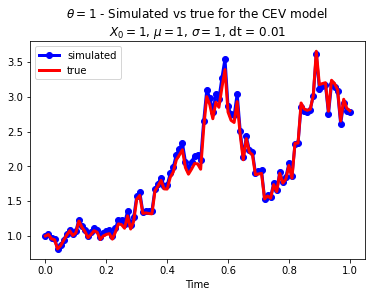

In [8]:
T = 1
dt = 0.01
N = int(T/dt)
t = np.linspace(0,1,N+1)
mu  = 1
sigma = 1
theta = 1
X0 = 1
X, dW = EM(dt, T, mu, sigma, theta, X0)
W = np.zeros(N+1)
W[1::] = np.cumsum(dW)
X_true = X0*np.exp((mu-sigma**2/2)*t+sigma*W)

fig, ax = plt.subplots()
ax.plot(t, X, color = 'blue',  marker = 'o', label='simulated', linewidth = 3)
ax.plot(t, X_true, color = 'red', label='true', linewidth = 3)
ax.set_xlabel('Time')
title = r'$\theta=$' + str(theta) + ' - Simulated vs true for the CEV model \n' + r'$X_0=$' + str(X0) + r', $\mu=$' + str(mu) + r', $\sigma=$' + str(sigma) + f', dt = {dt}'
ax.set_title(title)
ax.legend()
#plt.savefig('EM_theta1.png', dpi = 1200)

### $\theta=0$ 

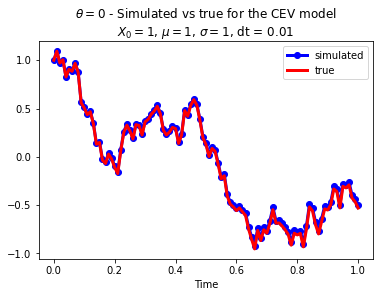

In [9]:
T = 1
dt = 0.01
N = int(T/dt)
t = np.linspace(0,1,N+1)
mu  = 1
sigma = 1
theta = 0
X0 = 1

X, dW = EM(dt, T, mu, sigma, theta, X0)
W = np.zeros(N+1)
W[1::] = np.cumsum(dW)
integral = np.zeros(N+1)
for k in range(N):
    integral[k+1] = integral[k] + dW[k]*math.exp(-mu*t[k])
X_true = np.exp(mu*t) * (X0 + sigma * integral)


fig, ax = plt.subplots()
ax.plot(t, X, color = 'blue', marker = 'o', label='simulated', linewidth = 3)
ax.plot(t, X_true, color = 'red', label='true', linewidth = 3)
ax.set_xlabel('Time')
title = r'$\theta=$' + str(theta) + ' - Simulated vs true for the CEV model \n' + r'$X_0=$' + str(X0) + r', $\mu=$' + str(mu) + r', $\sigma=$' + str(sigma) + f', dt = {dt}'
ax.set_title(title)
ax.legend()
#plt.savefig('EM_theta0.png', dpi = 1200)

## Estimation of the Strong error for the EM scheme at final time T.

In [10]:
def compute_strong_error(dt, T, mu, sigma, theta, X0, M): 
    ''' Compute the strong error between the EM scheme and the true solution 
    at final time T for a given time step dt 
    by averaging over the error over M runs. 
    
    mu, sigma, theta, X0 are the model parameter in the CEV model ''' 
    
    error = np.zeros(M)
    N = int(T/dt)
    t = np.linspace(0,1,N+1)
    for i in range(M):  # sum over the samples 
        # one run of the Euler-Maruyama scheme 
        X, dW = EM(dt, T, mu, sigma, theta, X0)
        W = np.cumsum(dW)
        # compute the exact solution at the final time T
        if theta == 1: 
            X_true_final = X0*np.exp((mu-sigma**2/2)*T+sigma*W[-1])
        if theta == 0: 
            integral = np.dot(np.exp(-mu*t[:-1]), dW)
            X_true_final = np.exp(mu*T) * (X0 + sigma * integral)
        # error between the exact solution and the numerical solution     
        error[i] = np.abs(X[-1]-X_true_final)    
    
    return np.mean(error)

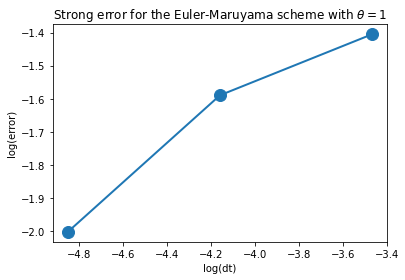

In [11]:
# model parameter 
T = 1
mu  = 1
sigma = 1

theta = 1
# theta = 0

X0 = 1

M = 1000 # number of samples 

###########   for theta = 0,1
# values of the time step
dt_values = np.array([2**(-k) for k in range(5, 8)])

# Compute the strong error for each value of dt in dt_values 
error = np.zeros(len(dt_values))
for i, dt in enumerate(dt_values): 
    error[i] = compute_strong_error(dt, T, mu, sigma, theta, X0, M)

# plots
fig, ax = plt.subplots()
ax.plot(np.log(dt_values), np.log(error), 'o-', linewidth=2, markersize=12)
ax.set_title('Strong error for the Euler-Maruyama scheme with '+r'$\theta=$' + str(theta))
ax.set_xlabel('log(dt)')
ax.set_ylabel('log(error)')
name = f'EM_strong_error_theta{theta}.png'
#plt.savefig(name, dpi = 1200)

## SENSITIVITY ANALYSIS OF THE EM SCHEME 

     with respect to model parameter sigma 

### sensitivity w.r.t. $\sigma$

0.1
0.2
0.30000000000000004
0.4
0.5
0.6
0.7000000000000001
0.8
0.9
1.0


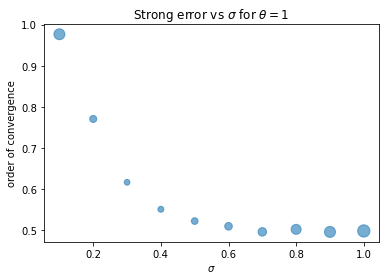

In [12]:
M = 5000 # number of samples 

X0 = 1 
T = 1

# values of the time step
dt_values = np.array([2**(-k) for k in range(5, 13)])

theta = 1 
# theta = 0 

mu = 1 

sigma_values = np.linspace(0.1, 1, 10) 

result = np.zeros((len(sigma_values),2)) # 1st column for gamma, 2nd column for C

for i, sigma in enumerate(sigma_values): 
    print(sigma)
    # given the value sigma, 
    # compute the strong error for each value of dt in dt_values 
    error = np.zeros(len(dt_values))
    for j, dt in enumerate(dt_values): 
        error[j] = compute_strong_error(dt, T, mu, sigma, theta, X0, M)
    # linear regression to estimate slope and intercept - stored in result 
    result[i] = np.polyfit(np.log(dt_values), np.log(error), deg=1)    

# plot 
plt.scatter(sigma_values, result[:,0], s = 10**2*np.exp(result[:,1]), alpha = 0.6) 
plt.title(r'Strong error vs $\sigma$ for $\theta=$' + f'{theta}')
plt.xlabel(r'$\sigma$')
plt.ylabel('order of convergence')
plt.savefig('StrongError_vs_Sigma_theta'+f'{theta}.png', dpi = 1200)

### sensitivity w.r.t. $\mu$. 

In [13]:
M = 5000 # number of samples 

X0 = 1 
T = 1

# values of the time step
dt_values = np.array([2**(-k) for k in range(5, 12)])

#theta = 1 
theta = 0 

sigma = 1 

mu_values = np.linspace(0, 5, 10) 

result = np.zeros((len(mu_values),2)) # 1st column for gamma, 2nd column for C

for i, mu in enumerate(mu_values): 
    print(mu)
    # given the value sigma, 
    # compute the strong error for each value of dt in dt_values 
    error = np.zeros(len(dt_values))
    for j, dt in enumerate(dt_values): 
        error[j] = compute_strong_error(dt, T, mu, sigma, theta, X0, M)
    # linear regression to estimate slope and intercept - stored in result 
    result[i] = np.polyfit(np.log(dt_values), np.log(error), deg=1)    

0.0
0.5555555555555556
1.1111111111111112
1.6666666666666667
2.2222222222222223
2.7777777777777777
3.3333333333333335
3.8888888888888893
4.444444444444445
5.0


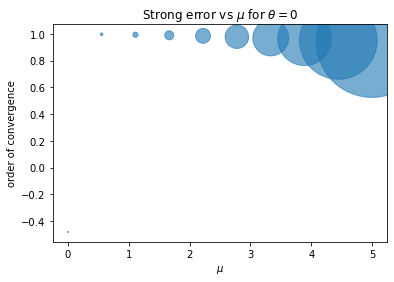

In [14]:
# plot 
plt.scatter(mu_values, result[:,0], s = 10*np.exp(result[:,1]), alpha = 0.6) 
plt.title(r'Strong error vs $\mu$ for $\theta=$' + f'{theta}')
plt.xlabel(r'$\mu$')
plt.ylabel('order of convergence')
plt.savefig('StrongError_vs_mu_theta'+f'{theta}.png', dpi = 1200)

## Call valuation with the CEV model 

In [15]:
def Call_Value_CEV (X0, r, sigma, theta, T, dt, M, K):
   # Computethe value of a call with time to maturoty equal to T, strike K
   # using the CEV model with parameter X0, mu, sigma, theta
   # dt is the time step used in the Euler-Maruyama scheme (dt=0.01 works fine) 
   # the call is valued doing M runs of the CEV model (discretized with the EM scheme) and taking their average.
    val = []
    for _ in range(M): 
        
        X, dW = EM(dt, T, r, sigma, theta, X0)
        result = max(0, np.exp(-r*T)*(X[-1]-K))
        
        val.append(result)
    
    return np.mean(val)

In [16]:
## when theta=1 the CEV model is Black-Scholes 
X0 = 100
r = 0.03
sigma = 0.5
theta = 1 
T = 1 
dt = 0.001
M = 5000
K = 10

price_with_CEV = Call_Value_CEV (X0, r, sigma, theta, T, dt, M, K)
price_with_BS = BSF(X0, K, T, sigma, r) 
relative_error = np.abs(price_with_CEV-price_with_BS)/price_with_BS
print(f'the relative error between CEV estimation and the exact BS formula is {relative_error}')

the relative error between CEV estimation and the exact BS formula is 0.019606942975173146


Text(0, 0.5, 'price')

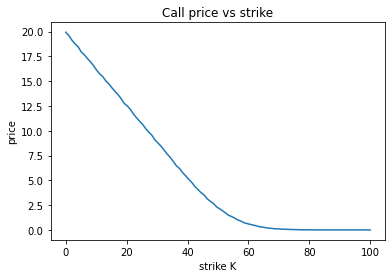

In [17]:
### PLTO OF THE PRICE vs STRIKE IN THE CEV MODEL 
# CEV parameter
X0=20
r = 1
sigma = 1
theta = 0.5
T = 1
dt = 0.01
strike_values = np.linspace(0,100, 100)
M = 5000 # number of samples 

call_value = [Call_Value_CEV (X0, r, sigma, theta, T, dt, M, K) for K in strike_values]

plt.plot(strike_values, call_value)
plt.title('Call price vs strike')
plt.xlabel('strike K')
plt.ylabel('price')

# Getting stock data from Yahoo Finance

In [18]:
# get the historical US treasuray rates for 1 month, 3 months, 6 months, 1 year, 2 years, 3 years
yc = dr(['DGS1MO', 'DGS3MO', 'DGS6MO', 'DGS1', 'DGS2', 'DGS3'] , 'fred')
# the last row is today
USr = yc.iloc[-1,:].to_numpy()/100 

In [19]:
# Pull information from Yahoo Finance for the stock 'ticker'
ticker = 'MSFT' # MSFT = Microsoft Corporation
stock = options.get_calls(ticker) 

In [20]:
# get time to maturity in years (the T variable in Black-Scholes) 
today = datetime.today().date() # get todays date
Maturity = options.get_expiration_dates(ticker) # pull maturity dates for the option
Maturity = [m.replace(',', '') for m in Maturity] # format 
time_to_maturity = [(parser.parse(m).date() - today).days/365 for m in Maturity]

In [21]:
# select the calls corresponding to a given maturity date chosen from the list 'Maturity'
chosen_maturity = Maturity[5]  
T = time_to_maturity[5] 
opt = options.get_calls(ticker, chosen_maturity)
# list of call prices and strike for this matiruty date 
CallPrice = opt['Last Price'] 
strike = opt['Strike'] 
# obtain the interest rate by linearly interpolating the US interest rate contained in USr 
r = np.interp(T, [1/12, 3/12, 6/12, 1, 2, 3], USr) 

In [22]:
S = get_data(ticker).iloc[-1,3] # Latest asset price

# Implicit volatility using real data
Compute the implicit volatility using the real data obtained in the previous cells.

In [23]:
implied_volatility_real = [Implicit_volatility (S, T, r, K=strike[i], C_real=CallPrice[i], a=0, b=200, tol=10**(-5)) 
                      for i in range(len(strike)) ]

incorrect interval
incorrect interval
incorrect interval


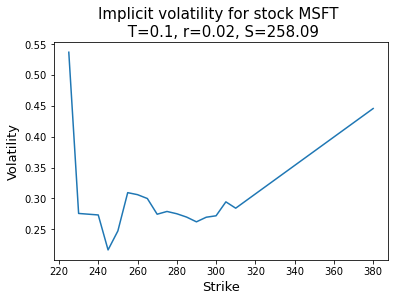

In [24]:
plt.plot(strike, implied_volatility_real)
plt.title(f'Implicit volatility for stock {ticker} \n T={np.around(T,2)}, r={np.around(r,2)}, S={np.around(S,2)}',
         fontsize=15)
plt.xlabel('Strike', fontsize=13)
plt.ylabel('Volatility', fontsize=13)
plt.savefig('implied_vol_MSFT.png', dpi=1200)

# Implicit volatility using prices estimated using the CEV model


In [25]:
# parameters values for the CEV model 
# I take the same S, T and r as in the previous cells

theta_values = np.arange(0.7, 1.5, 0.1)
sigma_values = np.arange(0.1, 0.8, 0.1)
strike_values = np.arange(200,300,5) # asset price today is S=256

# the implies volatility for each value of theta, sigma, strike
implied_volatility_sim = np.zeros((len(theta_values), len(sigma_values), len(strike_values)))

# the estimation of the call price in the CEV model 
call_price_est = np.zeros((len(theta_values), len(sigma_values), len(strike_values)))
# number of samples M and time step dt used to estimate the value of a call in the CEV model 
dt = 0.001
M = 5000   

for i, theta in enumerate(theta_values): 
    
    print(theta)
    
    for j, sigma in enumerate(sigma_values): 
        
        for k, K in enumerate(strike_values): 
            
            call_price_est[i,j,k] = Call_Value_CEV (S, r, sigma, theta, T, dt, M, K)
            
            implied_volatility_sim[i,j,k] = Implicit_volatility (S, T, r, K, call_price_est[i,j,k], a=0, b=10, tol=10**(-3))

0.7
incorrect interval
incorrect interval
incorrect interval
incorrect interval
incorrect interval
incorrect interval
incorrect interval
incorrect interval
incorrect interval
incorrect interval
incorrect interval
incorrect interval
incorrect interval
incorrect interval
incorrect interval
incorrect interval
incorrect interval
incorrect interval
incorrect interval
incorrect interval
incorrect interval
incorrect interval
incorrect interval
incorrect interval
incorrect interval
incorrect interval
incorrect interval
incorrect interval
incorrect interval
incorrect interval
incorrect interval
incorrect interval
incorrect interval
0.7999999999999999
incorrect interval
incorrect interval
incorrect interval
incorrect interval
incorrect interval
incorrect interval
incorrect interval
incorrect interval
incorrect interval
incorrect interval
incorrect interval
incorrect interval
incorrect interval
incorrect interval
incorrect interval
incorrect interval
incorrect interval
incorrect interval
incorrec

<ipython-input-6-eed6c04f8eca>:7: RuntimeWarning: invalid value encountered in double_scalars
  X[k+1] = X[k]*(1 + dt*mu) + sigma * X[k]**theta * dW[k]


incorrect interval
1.4
incorrect interval
incorrect interval
incorrect interval
incorrect interval
incorrect interval
incorrect interval
incorrect interval
incorrect interval
incorrect interval
incorrect interval
incorrect interval
incorrect interval
incorrect interval
incorrect interval


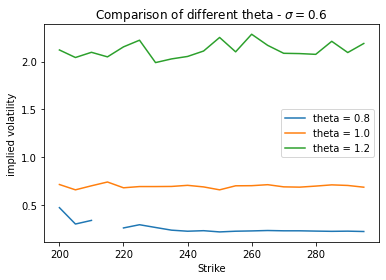

In [26]:
fig, ax = plt.subplots()

j = 6
sigma = sigma_values[5]

for i in [1, 3, 5]: 
    ax.plot(strike_values, implied_volatility_sim[i,j,:], label = f'theta = {np.around(theta_values[i],2)}')
    
ax.set_title('Comparison of different theta - '+ r'$\sigma=$' + str(sigma))
ax.set_xlabel('Strike')
ax.set_ylabel('implied volatility')
ax.legend()
name = f'Implied_vol_CEV_sigma{sigma}.png'
plt.savefig(name, dpi = 1200)